# Cluster visualization

This is a continuation of .



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math

# 1.1m rows
projects_ff = pd.read_csv('Projects.csv')
# 4.6m rows
donations_ff = pd.read_csv('Donations.csv')
# Some donations were missing valid project IDs...
df = donations_ff.merge(projects_ff, on="Project ID", how="inner")
df.head(3)

# REDUCED SIZE FOR TESTING/DEVELOPMENT
donations = df.sample(n=50000)[['Project ID', 'Donation ID', 'Donor ID', 'Donation Amount', 'Donation Received Date']]

projects = projects_ff.loc[ projects_ff["Project ID"].isin(donations["Project ID"]) ].copy()
projects = projects.reset_index(drop = True)

print(" loaded", len(donations), "donations and", len(projects), "projects.")

 loaded 50000 donations and 46654 projects.


In [3]:
#
# Model training
#

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Preprocessing of text data
textfeats = ["Project Essay"]
for cols in textfeats:
    projects[cols] = projects[cols].astype(str) 
    projects[cols] = projects[cols].astype(str).fillna('') # FILL NA
    projects[cols] = projects[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently 
text = pd.Series(projects["Project Essay"])

basic_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words='english')
tuned_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words='english', 
                                   ngram_range = (1,3), max_features=2500 )
vectorizer = tuned_vectorizer

PF_MATRIX = vectorizer.fit_transform(text)
tfidf_feature_names = vectorizer.get_feature_names()

project_row_to_id = dict(projects['Project ID'])
project_id_to_row = {value: key for key, value in project_row_to_id.items()}

PF_MATRIX


<46654x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 4731967 stored elements in Compressed Sparse Row format>

In [6]:
##
## Split the donations
##
from sklearn.model_selection import train_test_split 

donations_train, donations_test = train_test_split(donations, test_size=0.5)
print(len(donations_train), len(donations_test))

def get_future_donation_rows(donor_id):
    donor_projects_test = donations_test.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    return list(donor_projects_test["Project ID"].map(project_id_to_row))

def get_past_donation_rows(donor_id):
    donor_projects_train = donations_train.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    return list(donor_projects_train["Project ID"].map(project_id_to_row))


25000 25000


Next we build a list of donors ranked by the number of projects to which they have each contributed.  We broke down the number of projects they contributed to in terms of training (which we view as past projects) and test (which we view as future projects that we would like to predict).

In [7]:
##
## Find the top donors (by number of projects)
##

MIN_FREQ = 3

top_donors = pd.DataFrame(donations_train['Donor ID'].value_counts())
top_donors.columns = ['freq']
top_donors['Donor ID'] = top_donors.index
top_donors = top_donors.loc[top_donors.freq >= MIN_FREQ]

td_test = pd.DataFrame(donations_test.merge( top_donors, on="Donor ID", how="inner" ).groupby("Donor ID")["Project ID"].count())
td_test.columns = ['test_freq']
td_test = td_test.loc[td_test.test_freq >= MIN_FREQ]

top_donors = top_donors.merge(td_test, on="Donor ID", how="inner")
top_donors[:30]



,freq,Donor ID,test_freq
0,100,39df9399f5384334a42905bcf0acdcbf,104
1,72,237db43817f34988f9d543ca518be4ee,54
2,46,a0e1d358aa17745ff3d3f4e4909356f3,48
3,44,6f74ffb17cbb2b616b1eef06bd4acd0c,39
4,36,24ecca49933c30a0beb83090591720c0,28
5,35,a1929a1172ad0b3d14bc84f54018c563,39
6,34,19f24640d9da49f6f8b4c9938c049591,25
7,32,6a35a7514005c04f8520e5d8f7657d91,28
8,31,74f7db06bcd9557d1e992dc029db69cc,31
9,29,b51c76411b51751f45527c63c69ead9e,23


This is a way to visualize the distinctions being made by the PF_MATRIX encoding.


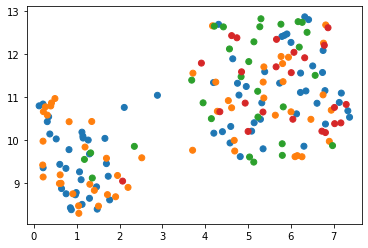

In [25]:
import random
import umap
import seaborn as sns

cnt = 0
plot_data = pd.DataFrame()

for tid in [top_donors.iloc[random.choice(range(20))]["Donor ID"], top_donors.iloc[random.choice(range(20))]["Donor ID"] ]:
    X = PF_MATRIX[np.array(get_past_donation_rows(tid)),:]
    Y = PF_MATRIX[np.array(get_future_donation_rows(tid)),:]
    pdata = pd.DataFrame(X.todense())
    pdata["target"] = cnt
    cnt += 1
    qdata = pd.DataFrame(Y.todense())
    qdata["target"] = cnt
    cnt += 1
    plot_data = plot_data.append(pdata)
    plot_data = plot_data.append(qdata)
#plot_data

reducer = umap.UMAP()
embedding = reducer.fit_transform(plot_data.drop(['target'], axis=1))

plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in plot_data.target])
plt.gca().set_aspect('equal', 'datalim')
